In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
np.random.seed(42) 


In [2]:
df_train=pd.read_csv('datasets/clean/processedtrain.csv')
df_test=pd.read_csv('datasets/clean/processedtest.csv')
data=df_train.copy()

In [3]:

#label encoding 
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

df_train['NObeyesdad']=encoder.fit_transform(df_train['NObeyesdad'])
df_train['NObeyesdad'].value_counts()

df_test['NObeyesdad']=encoder.fit_transform(df_test['NObeyesdad'])
df_test.head(11)
log_col =  ['Weight','Height','FAVC','FAF','TUE']
X_train=df_train[log_col]
y_train=df_train.NObeyesdad


X_test=df_test[log_col]
y_test=df_test.NObeyesdad


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.fit_transform(X_test)

In [4]:
def plot_decision_boundary(svm, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.scatter(svm.support_vectors[:, 0], svm.support_vectors[:, 1], 
                s=80, facecolors='none', edgecolors='k')
    plt.title('SVM Decision Boundary')
    plt.show()

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def rbf_kernel(x1, x2, gamma=0.1):
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    # Ensure proper broadcasting
    return np.exp(-gamma * np.sum((x1[:, np.newaxis] - x2)**2, axis=-1))




E[i] = f(x[i]) - y[i] (prediction error).

y[i] * E[i] = y[i] f(x[i]) - 1 (margin violation check).

What tol Controls:
y[i] * E[i] < -tol:
The point is misclassified or inside the margin (needs adjustment if αᵢ < C).

y[i] * E[i] > tol:
The point is correctly classified but too far from the margin (needs adjustment if αᵢ > 0).

-tol ≤ y[i] * E[i] ≤ tol:
The point satisfies the KKT conditions (no update needed).



In [5]:
def svm_optimization(X, y, kernel, C, tol=1e-3, max_passes=20):
    m, n = X.shape
    alphas = np.zeros(m)  
    # Initialize all Lagrange multipliers to 0 
    # point 0<a<c are support vectors
    b = 0
    
    for _ in range(max_passes):
        num_changed_alphas = 0 #updates for each pass
        for i in range(m):
            # Compute Ei
            Ki = kernel(X[i].reshape(1,-1), X) #claculates similarity between i-point and all points 
            Ei = np.sum(alphas * y * Ki.ravel()) + b - y[i]#how wrong current prediction is for point i

            #check KKT condition
            
            if (y[i]*Ei < -tol and alphas[i] < C) or (y[i]*Ei > tol and alphas[i] > 0):
                # Select second alpha randomly
                j = np.random.choice([k for k in range(m) if k != i])
                
                # Compute Ej
                Kj = kernel(X[j].reshape(1,-1), X)
                Ej = np.sum(alphas * y * Kj.ravel()) + b - y[j]
                
                # Save old alphas
                alpha_i_old, alpha_j_old = alphas[i], alphas[j]
                
                # Compute L and H bounds 
                if y[i] != y[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[i] + alphas[j] - C)
                    H = min(C, alphas[i] + alphas[j])
                
                if L == H:
                    continue
                
                # Compute eta
                eta = 2 * kernel(X[i].reshape(1,-1), X[j].reshape(1,-1)) - \
                      kernel(X[i].reshape(1,-1), X[i].reshape(1,-1)) - \
                      kernel(X[j].reshape(1,-1), X[j].reshape(1,-1))
                
                """
                The distance is zero (meaning ϕ(xi)=ϕ(xj)ϕ(x i​)=ϕ(x j​), i.e., the kernel is degenerate)
                The objective function is flat or convex in this subspace
                """
                if eta >= 0:
                    continue
                
                #The kernel matrix is locally positive definite, meaning the objective W(α) is strictly concave i
                # Update alpha_j
                alphas[j] -= y[j] * (Ei - Ej) / eta
                alphas[j] = np.clip(alphas[j], L, H)
                
                if abs(alphas[j] - alpha_j_old) < tol:
                    continue
                
                # Update alpha_i
                alphas[i] += y[i] * y[j] * (alpha_j_old - alphas[j])
                
                # Update b
                b1 = b - Ei - y[i]*(alphas[i]-alpha_i_old)*kernel(X[i].reshape(1,-1), X[i].reshape(1,-1)) \
                     - y[j]*(alphas[j]-alpha_j_old)*kernel(X[i].reshape(1,-1), X[j].reshape(1,-1))
                
                b2 = b - Ej - y[i]*(alphas[i]-alpha_i_old)*kernel(X[i].reshape(1,-1), X[j].reshape(1,-1)) \
                     - y[j]*(alphas[j]-alpha_j_old)*kernel(X[j].reshape(1,-1), X[j].reshape(1,-1))
                
                if 0 < alphas[i] < C: #ai is SV
                    b = b1
                elif 0 < alphas[j] < C: #aj is SV
                    b = b2
                else:
                    b = (b1 + b2)/2
                
                num_changed_alphas += 1
        
        if num_changed_alphas == 0:
            break
    
    return alphas, b

In [6]:
class SVM:
    def __init__(self, kernel=linear_kernel, C=1.0):
        self.kernel = kernel
        self.C = C
        self.alphas = None
        self.b = None
        self.support_vectors = None
        self.support_vector_labels = None
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.alphas, self.b = svm_optimization(X, y, self.kernel, self.C)
        
        support_vector_indices = np.where(self.alphas > 1e-3)[0] #SELECT SUPPORT VECTORS
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]
        self.alphas = self.alphas[support_vector_indices]
    
    def predict(self, X):
        X = np.asarray(X)
        # Calculate kernel between support vectors and new data
        K = self.kernel(self.support_vectors, X)  # shape: (n_support, n_samples)
        
        # Calculate decision values
        y_pred = np.dot((self.alphas * self.support_vector_labels).T, K) + self.b
        return np.sign(y_pred).astype(int)


In [7]:
class MultiClassSVM:
    def __init__(self, kernel=linear_kernel, C=1.0):
        self.kernel = kernel
        self.C = C
        self.binary_classifiers = {}

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)       
        self.classes = np.unique(y)
        for class_label in self.classes:
            binary_y = np.where(y == class_label, 1, -1)
            svm = SVM(kernel=self.kernel, C=self.C)
            svm.fit(X, binary_y)
            self.binary_classifiers[class_label] = svm

    def predict(self, X):
        X = np.asarray(X)
        decision_values = np.zeros((X.shape[0], len(self.classes)))
        
        for i, class_label in enumerate(self.classes):
            svm = self.binary_classifiers[class_label]
            # Get decision values for each classifier
            decision_values[:, i] = svm.predict(X)
            
        return self.classes[np.argmax(decision_values, axis=1)]




In [8]:
multi_svm = MultiClassSVM(kernel=lambda x1, x2: rbf_kernel(x1, x2, gamma= 1), C=15.0)
multi_svm.fit(x_train_scaled, y_train.values)  # Explicit conversion to numpy
y_pred = multi_svm.predict(x_test_scaled)
y_pred_train = multi_svm.predict(x_train_scaled)
test_acc = accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_train,y_pred_train )

print(f"Multi-class SVM accuracy: {accuracy:.3f}")
print(f"Multi-class SVM accuracy: {test_acc:.3f}")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25548\2958351301.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alphas[j] -= y[j] * (Ei - Ej) / eta


Multi-class SVM accuracy: 0.957
Multi-class SVM accuracy: 0.886


In [9]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77        24
           1       1.00      0.72      0.84        32
           2       0.88      1.00      0.94        29
           3       0.95      0.95      0.95        38
           4       1.00      0.93      0.96        28
           5       0.86      0.92      0.89        26
           6       1.00      0.74      0.85        34

    accuracy                           0.89       211
   macro avg       0.90      0.89      0.88       211
weighted avg       0.91      0.89      0.89       211



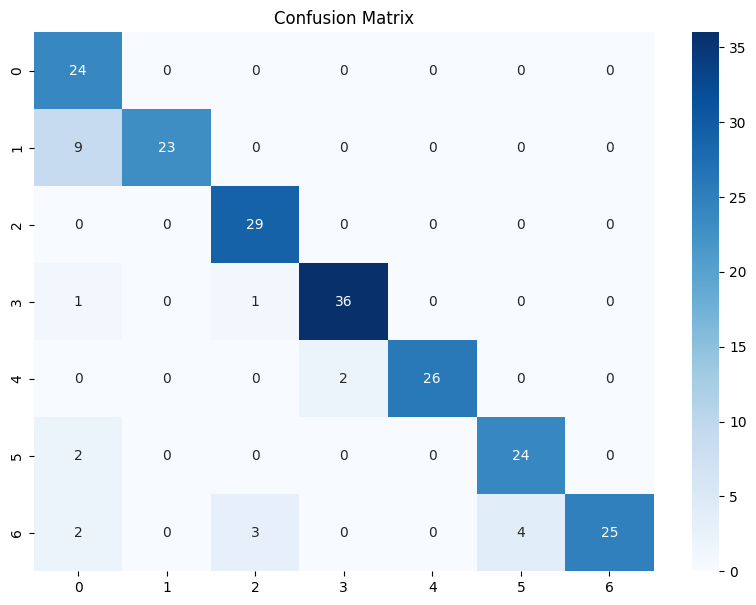

In [10]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()